In [134]:
import pandas as pd
import re
import spacy
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

Load Dataset

In [70]:
df = pd.read_csv('labeled_data.csv')

In [71]:
df.shape

(24783, 7)

In [72]:
df.head()
# class label for majority of CF users. 0 - hate speech 1 - offensive language 2 - neither

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


Data cleaning

In [73]:
df.columns

Index(['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither',
       'class', 'tweet'],
      dtype='object')

In [74]:
df.drop(['Unnamed: 0','count', 'hate_speech', 'offensive_language', 'neither'], axis=1, inplace=True)

In [75]:
df.head()

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [76]:
# null values
df.isna().sum()

,0
class,0
tweet,0


In [77]:
df['tweet'].iloc[0]

"!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out..."

In [78]:
def clean_tweet(text):
    text = text.lower()
    text = re.sub(r'@[\w]+', '', text)  # mentions
    text = re.sub(r'#', '', text)  # hashtag symbol but keep word
    text = re.sub(r'[^\w\s]', '', text)  # punctuation/symbols
    text = re.sub(r'\s+', ' ', text).strip()  # extra spaces
    return text
df['processed_tweet'] = df['tweet'].apply(clean_tweet)

In [79]:
df.drop(['tweet'], axis=1, inplace=True)

In [80]:
df.head()

,class,processed_tweet
0,2,rt as a woman you shouldnt complain about clea...
1,1,rt boy dats coldtyga dwn bad for cuffin dat ho...
2,1,rt dawg rt you ever fuck a bitch and she start...
3,1,rt she look like a tranny
4,1,rt the shit you hear about me might be true or...


Lemmatization

In [81]:
# we can use nltk library (NLP tool kit) or SpiCy library (more efficient and interactive)
nlp = spacy.load('en_core_web_sm') # since we are working with english dataset

In [82]:
def lemmatization(text):
    doc = nlp(text)
    lemma_list = [token.lemma_ for token in doc if not token.is_punct and not token.is_space]
    return ' '.join(lemma_list)

In [83]:
df['lemma_tweet'] = df['processed_tweet'].apply(lemmatization)

In [84]:
df.head()

,class,processed_tweet,lemma_tweet
0,2,rt as a woman you shouldnt complain about clea...,rt as a woman you should not complain about cl...
1,1,rt boy dats coldtyga dwn bad for cuffin dat ho...,rt boy dat coldtyga dwn bad for cuffin dat hoe...
2,1,rt dawg rt you ever fuck a bitch and she start...,rt dawg rt you ever fuck a bitch and she start...
3,1,rt she look like a tranny,rt she look like a tranny
4,1,rt the shit you hear about me might be true or...,rt the shit you hear about I might be true or ...


Stepwords removal

In [85]:
def remove_stopwords(text):
    doc = nlp(text)
    stopword_list = [token.text for token in doc if not token.is_stop]
    return ' '.join(stopword_list)

In [86]:
df['final_tweet'] = df['lemma_tweet'].apply(remove_stopwords)

In [87]:
df.drop(['processed_tweet', 'lemma_tweet'], axis=1, inplace=True)

In [88]:
df.head()

,class,final_tweet
0,2,rt woman complain clean house amp man trash
1,1,rt boy dat coldtyga dwn bad cuffin dat hoe 1st...
2,1,rt dawg rt fuck bitch start cry confuse shit
3,1,rt look like tranny
4,1,rt shit hear true faker bitch tell ya 57361


Tokenizer

In [135]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(df['final_tweet'])  # during training
sequences = tokenizer.texts_to_sequences(df['final_tweet'])

Padding

In [136]:
df['tweet_length'] = df['final_tweet'].apply(lambda x: len(x.split()))
df['tweet_length'].describe()

,tweet_length
count,24783.000000
mean,7.369850
std,3.666456
min,1.000000
25%,4.000000
50%,7.000000
75%,10.000000
max,29.000000


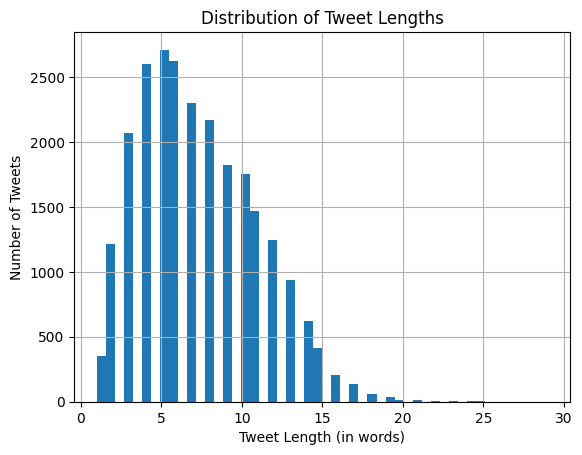

In [137]:
df['tweet_length'].hist(bins=50)
plt.xlabel("Tweet Length (in words)")
plt.ylabel("Number of Tweets")
plt.title("Distribution of Tweet Lengths")
plt.show()

In [138]:
sentinel_length = 20
embedded_tweet = pad_sequences(one_hot_representation, padding='pre', maxlen=sentinel_length)
# example : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 432, 543, 98]

In [139]:
X = np.array(embedded_tweet)
y = np.array(df['class'])

Balance Data

In [140]:
df['class'].value_counts()

,count
class,
1,19190
2,4163
0,1430


In [141]:
smote = SMOTE(sampling_strategy='minority')
X, y = smote.fit_resample(X, y)

Splitting

In [142]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [143]:
X_train.shape, X_test.shape

((34034, 20), (8509, 20))

Building stacked LSTM

In [144]:
dimension = 50

model = keras.Sequential([
    # embedding layer
    keras.layers.Embedding(vocab_size, dimension),

    # Bi-LSTM layers (Stacked)
    keras.layers.Bidirectional(keras.layers.LSTM(100, return_sequences=True)),
    keras.layers.Bidirectional(keras.layers.LSTM(50, return_sequences=True)),
    keras.layers.Bidirectional(keras.layers.LSTM(50)),

    # output layer for multi-class classification
    keras.layers.Dense(3, activation='softmax')
])

# compiling
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [145]:
model.build(input_shape=(None, sentinel_length)) # new version of keras ( input will be batches of sequences, each of length sentinel_length)
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ (None, 20, 50)         │       500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_21                │ (None, 20, 200)        │       120,800 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_22                │ (None, 20, 100)        │       100,400 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_23                │ (None, 100)            │        60,400 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 781,903 (2.98 MB)

 Trainable params: 781,903 (2.98 MB)

 Non-trainable params: 0 (0.00 B)

In [146]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    filepath="/content/best_model.keras",
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, checkpoint]
)

Epoch 1/10
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 129s 107ms/step - accuracy: 0.8024 - loss: 0.4853 - val_accuracy: 0.9187 - val_loss: 0.2498
Epoch 2/10
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 134s 100ms/step - accuracy: 0.9391 - loss: 0.1932 - val_accuracy: 0.9151 - val_loss: 0.2757
Epoch 3/10
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 111s 105ms/step - accuracy: 0.9589 - loss: 0.1331 - val_accuracy: 0.9063 - val_loss: 0.2784
Epoch 4/10
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 139s 102ms/step - accuracy: 0.9683 - loss: 0.1055 - val_accuracy: 0.9030 - val_loss: 0.3430


Evaluation

In [147]:
pred = np.argmax(model.predict(X_test), axis=1)

266/266 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step


In [148]:
# y_test[:5]
# pred[:5]

In [149]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.95      0.92      0.94      3838
           1       0.93      0.93      0.93      3838
           2       0.75      0.86      0.80       833

    accuracy                           0.92      8509
   macro avg       0.88      0.90      0.89      8509
weighted avg       0.92      0.92      0.92      8509



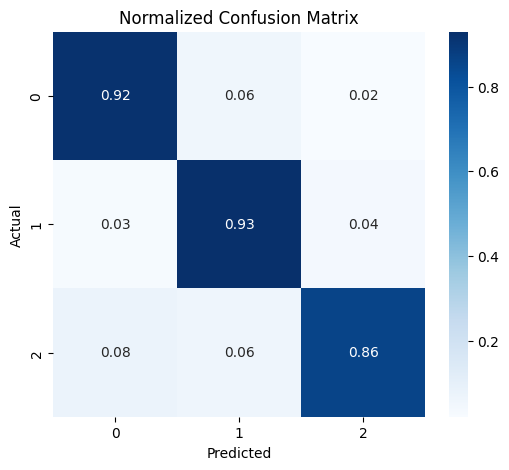

In [150]:
cm = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=[0,1,2], yticklabels=[0,1,2])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Normalized Confusion Matrix')
plt.show()

In [151]:
import pickle
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)
